In [1]:
import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import sys
import pandas as pd
import pickle
import numpy as np
from tqdm import tqdm
from datetime import datetime
import copy
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
import platform; print(platform.platform())

macOS-14.6-arm64-arm-64bit


In [3]:
df = pd.read_csv('/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/labelled_data_500_5bps.csv')

In [4]:
x = pd.to_datetime(df['date']).value_counts()
x.sort_index().index

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-15', '2021-06-16', '2021-06-17',
               '2021-06-18', '2021-06-21', '2021-06-22'],
              dtype='datetime64[ns]', name='date', freq=None)

In [5]:
df['label'].value_counts()

label
1    6138550
0     548143
2     528647
Name: count, dtype: int64

(array([ 548143.,       0.,       0.,       0.,       0., 6138550.,
              0.,       0.,       0.,  528647.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

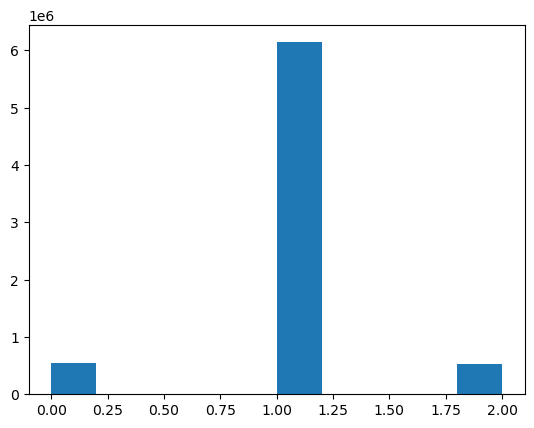

In [6]:
plt.hist(df['label'])

In [7]:
train_set = df[pd.to_datetime(df['date']) <= pd.to_datetime('2021-06-07')]
test_data = df[pd.to_datetime(df['date']) == pd.to_datetime('2021-06-08')]
train_set.head()

,date,SP1,SV1,BP1,BV1,SP2,SV2,BP2,BV2,SP3,...,BV3,SP4,SV4,BP4,BV4,SP5,SV5,BP5,BV5,label
0,2021-06-01,10200.0,3294,10150.0,61,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,2
1,2021-06-01,10200.0,3294,10150.0,59,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,2
2,2021-06-01,10200.0,3324,10150.0,59,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,2
3,2021-06-01,10200.0,3324,10150.0,43,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,2
4,2021-06-01,10200.0,3324,10150.0,43,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,687,2


In [8]:
train_data =  train_set.iloc[:int(np.floor(train_set.shape[0] * 0.8)),:]
eval_data = train_set.iloc[int(np.floor(train_set.shape[0] * 0.8)):,:]

In [9]:
def normalize_data(df,cols,norm):
    #Normalizing using z-score
    if norm=='Z':
        scaler = StandardScaler()
        scaler.fit(df[cols])
        data = scaler.transform(df[cols])
    
    
    #Normalizing using DecPrec
    if norm=='DecPrec':
        k_len = np.ceil(np.log10(df[cols].abs().max()))
        # print(k_len)
        data = df[cols]/(10**k_len)

    return data,scaler

In [10]:
train_input , scaler = normalize_data(train_data.iloc[:,1:-1],train_data.iloc[:,1:-1].columns,'Z')
train_label = train_data.iloc[:,-1].to_numpy()
eval_input = scaler.transform(eval_data.iloc[:,1:-1])
eval_label = eval_data.iloc[:,-1].to_numpy()
test_input = scaler.transform(test_data.iloc[:,1:-1])
test_label = test_data.iloc[:,-1].to_numpy()

In [11]:
del [train_data,test_data,eval_data,df,train_set]

In [12]:
s=0
cc=0
key=0
obj=0
for key,obj in locals().items():
    cc= sys.getsizeof(obj)/1000000
    s+=cc
    if cc>20:
        print(key,cc)
print(s,'mb')

0.016139 mb


In [13]:
np.isnan(eval_input).any()

False

In [14]:
class Dataset_LOB(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x,y, num_classes, T):
        """Initialization""" 
        # self.k = k
        self.num_classes = num_classes
        self.T = T
            
        # x = prepare_x(data)
        # y = get_label(data)
        x, y = data_classification(x, y, self.T)
        # y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [15]:
def data_classification(X, Y, T):
    [N, D] = X.shape
    # print(X.shape,T,N,Y.shape)
    df = np.array(X)
    # print(df.shape)
    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY


In [16]:
batch_size = 64
dataset_train = Dataset_LOB(train_input,train_label, num_classes=3, T=100)
dataset_eval = Dataset_LOB(eval_input,eval_label, num_classes=3, T=100)
dataset_test = Dataset_LOB(test_input,test_label, num_classes=3, T=100)

# test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

In [17]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_eval, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)
print(dataset_train.x.shape, dataset_test.y.shape)

torch.Size([1732671, 1, 100, 20]) torch.Size([282495])


In [18]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[ 0.1264,  0.4584,  0.1254,  ...,  1.3163,  0.1117, -0.2681],
          [ 0.1264,  0.4584,  0.1254,  ...,  1.3163,  0.1117, -0.2681],
          [ 0.1264,  0.4584,  0.1254,  ...,  1.3163,  0.1117, -0.2681],
          ...,
          [ 0.1264,  0.4537,  0.1254,  ...,  1.3157,  0.1117, -0.2676],
          [ 0.1264,  0.4541,  0.1254,  ...,  1.3157,  0.1117, -0.2676],
          [ 0.1264,  0.4541,  0.1254,  ...,  1.3157,  0.1117, -0.2676]]]],
       dtype=torch.float64)
tensor([1])
torch.Size([1, 1, 100, 20]) torch.Size([1])


In [19]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

device = mps_device

tensor([1.], device='mps:0')


In [20]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,5)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

In [21]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(mps_device)
# device = mps_device

deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [24]:
device

device(type='mps')

In [25]:
class_count = Counter(train_label)
class_weights = torch.Tensor([len(train_label)/c for c in pd.Series(class_count).sort_index().values])
class_weights = class_weights.to(device)  
criterion = nn.CrossEntropyLoss(class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [26]:
class_weights

tensor([10.5874,  1.2226, 11.4138], device='mps:0')

In [27]:
class EarlyStopping:
    def __init__(self, patience=1, path='./model.pt'):
        self.patience = patience
        self.path= path
        self.counter = 0
        self.best_score = np.inf
        self.early_stop = False
        self.best_test_epoch = 0
        
    def __call__(self, val_loss, model,it):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.best_test_epoch = it
    
        elif val_loss > self.best_score:
            self.counter +=1
            if self.counter >= self.patience:
                self.early_stop = True 
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            self.best_test_epoch = it

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [28]:
checkpoint_dir = '/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/fast-alphas/best_val_roLOB_2603_5bps.pt'

In [29]:
early_stopping = EarlyStopping(
        patience=15, 
        path=checkpoint_dir)

In [30]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)


    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        early_stopping(test_loss,model,it)
        if early_stopping.early_stop:
            print('Patience Exhausted')
            break

        dt = datetime.now() - t0
        print(dt)
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {early_stopping.best_test_epoch}')

    return train_losses, test_losses

In [ ]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=50)

  2%|▊                                      | 1/50 [27:21<22:20:44, 1641.72s/it]

0:27:21.710431
Epoch 1/50, Train Loss: 0.7918,           Validation Loss: 1.0318, Duration: 0:27:21.710431, Best Val Epoch: 0


  4%|█▌                                     | 2/50 [55:34<22:17:19, 1671.66s/it]

0:28:12.591237
Epoch 2/50, Train Loss: 0.7226,           Validation Loss: 1.0074, Duration: 0:28:12.591237, Best Val Epoch: 1


  6%|██▏                                  | 3/50 [1:22:46<21:35:28, 1653.80s/it]

0:27:12.541398
Epoch 3/50, Train Loss: 0.6988,           Validation Loss: 1.0118, Duration: 0:27:12.541398, Best Val Epoch: 1


  8%|██▉                                  | 4/50 [1:50:25<21:09:21, 1655.68s/it]

0:27:38.542965
Epoch 4/50, Train Loss: 0.6829,           Validation Loss: 1.0075, Duration: 0:27:38.542965, Best Val Epoch: 1


 10%|███▋                                 | 5/50 [2:17:53<20:39:43, 1652.97s/it]

0:27:28.169845
Epoch 5/50, Train Loss: 0.6756,           Validation Loss: 1.0062, Duration: 0:27:28.169845, Best Val Epoch: 4


 12%|████▍                                | 6/50 [2:45:21<20:10:59, 1651.35s/it]

0:27:28.165076
Epoch 6/50, Train Loss: 0.6706,           Validation Loss: 1.0010, Duration: 0:27:28.165076, Best Val Epoch: 5


 14%|█████▏                               | 7/50 [3:12:46<19:41:52, 1649.12s/it]

0:27:24.481381
Epoch 7/50, Train Loss: 0.6634,           Validation Loss: 1.0117, Duration: 0:27:24.481381, Best Val Epoch: 5


 16%|█████▉                               | 8/50 [3:40:10<19:13:21, 1647.65s/it]

0:27:24.485839
Epoch 8/50, Train Loss: 0.6576,           Validation Loss: 0.9728, Duration: 0:27:24.485839, Best Val Epoch: 7


 18%|██████▋                              | 9/50 [4:07:42<18:46:48, 1648.98s/it]

0:27:31.870882
Epoch 9/50, Train Loss: 0.6559,           Validation Loss: 0.9843, Duration: 0:27:31.870882, Best Val Epoch: 7


 20%|███████▏                            | 10/50 [4:35:10<18:19:03, 1648.58s/it]

0:27:27.663105
Epoch 10/50, Train Loss: 0.6511,           Validation Loss: 0.9778, Duration: 0:27:27.663105, Best Val Epoch: 7


 22%|███████▉                            | 11/50 [5:02:43<17:52:33, 1650.10s/it]

0:27:33.524354
Epoch 11/50, Train Loss: 0.6488,           Validation Loss: 1.0031, Duration: 0:27:33.524354, Best Val Epoch: 7


 24%|████████▋                           | 12/50 [5:30:19<17:26:03, 1651.68s/it]

0:27:35.278311
Epoch 12/50, Train Loss: 0.6479,           Validation Loss: 0.9789, Duration: 0:27:35.278311, Best Val Epoch: 7


In [ ]:
early_stopping.best_test_epoch

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(mps_device)
model.load_state_dict(torch.load('/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/fast-alphas/best_val_roLOB_2603_5bps.pt', map_location=mps_device))

/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_60065/2158610274.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/Users/jand

<All keys matched successfully>

# Training with adjusted class frequncy weighted loss function

In [24]:
n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    model.eval()
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)   

Test acc: 0.5460


In [25]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.5459636453742545
              precision    recall  f1-score   support

           0     0.2184    0.4208    0.2875     30509
           1     0.8248    0.5816    0.6822    224891
           2     0.1627    0.3910    0.2298     27095

    accuracy                         0.5460    282495
   macro avg     0.4019    0.4645    0.3998    282495
weighted avg     0.6958    0.5460    0.5962    282495



In [26]:
confusion_matrix(all_targets,all_predictions)

array([[ 12838,  14909,   2762],
       [ 42328, 130800,  51763],
       [  3625,  12876,  10594]])

# Train data Stats

In [27]:
n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for inputs, targets in train_loader:
    # Move to GPU
    model.eval()
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)   

Test acc: 0.8624


In [28]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.8624164656764036
              precision    recall  f1-score   support

           0     0.5838    0.9531    0.7241    163602
           1     0.9932    0.8415    0.9111   1417281
           2     0.5503    0.9603    0.6996    151788

    accuracy                         0.8624   1732671
   macro avg     0.7091    0.9183    0.7783   1732671
weighted avg     0.9158    0.8624    0.8749   1732671



In [29]:
confusion_matrix(all_targets,all_predictions)

array([[ 155927,    4856,    2819],
       [ 108388, 1192602,  116291],
       [   2774,    3259,  145755]])